(cobweb)=
# The Cobweb Model

The cobweb model is a model of prices and quantities in a given market, and how they evolve over time.

## Overview 

The cobweb model dates back to the 1930s and, while simple, it remains significant
because it shows the fundamental importance of *expectations*.

To give some idea of how the model operates, and why expectations matter, imagine the following scenario.

There is a market for soybeans, say, where prices and traded quantities
depend on the choices of buyers and sellers.

The buyers are represented by a demand curve --- they buy more at low prices
and less at high prices.

The sellers have a supply curve --- they wish to sell more at high prices and
less at low prices.

However, the sellers (who are farmers) need time to grow their crops.

Suppose now that the price is currently high.

Seeing this high price, and perhaps expecting that the high price will remain
for some time, the farmers plant many fields with soybeans.

Next period the resulting high supply floods the market, causing the price to drop.

Seeing this low price, the farmers now shift out of soybeans, restricting
supply and causing the price to climb again.

You can imagine how these dynamics could cause cycles in prices and quantities
that persist over time.

The cobweb model puts these ideas into equations so we can try to quantify
them, and to study conditions under which cycles persist (or disappear).

In this lecture, we investigate and simulate the basic model under different
assumptions regarding the way that producers form expectations.

Our discussion and simulations draw on [high quality lectures](https://comp-econ.org/CEF_2013/downloads/Complex%20Econ%20Systems%20Lecture%20II.pdf) by [Cars Hommes](https://www.uva.nl/en/profile/h/o/c.h.hommes/c.h.hommes.html).

We will use the following imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## History

Early papers on the cobweb cycle include {cite}`cobweb_model` and {cite}`hog_cycle`.

The paper {cite}`hog_cycle` uses the cobweb theorem to explain the prices of hog in the US over 1920--1950.

The next plot replicates part of Figure 2 from that paper, which plots the price of hogs at yearly frequency.

Notice the cyclical price dynamics, which match the kind of cyclical soybean price dynamics discussed above.

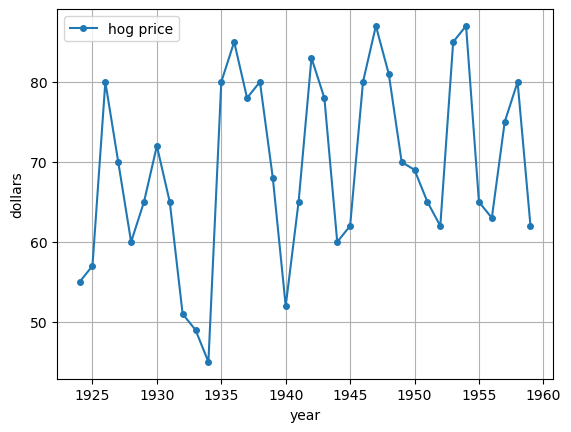

In [2]:
hog_prices = [55, 57, 80, 70, 60, 65, 72, 65, 51, 49, 45, 80, 85,
              78, 80, 68, 52, 65, 83, 78, 60, 62, 80, 87, 81, 70,
              69, 65, 62, 85, 87, 65, 63, 75, 80, 62]
years = np.arange(1924, 1960)
fig, ax = plt.subplots()
ax.plot(years, hog_prices, '-o', ms=4, label='hog price')
ax.set_xlabel('year')
ax.set_ylabel('dollars')
ax.legend()
ax.grid()
plt.show()

## The model

Let's return to our discussion of a hypothetical soybean market, where price is determined by supply and demand.

We suppose that demand for soybeans is given by

$$
    D(p_t) = a - b p_t
$$

where $a, b$ are nonnegative constants and $p_t$ is the spot (i.e, current market) price at time $t$.

($D(p_t)$ is the quantity demanded in some fixed unit, such as thousands of tons.)

Because the crop of soybeans for time $t$ is planted at $t-1$, supply of soybeans at time $t$ depends on *expected* prices at time $t$, which we denote $p^e_t$.

We suppose that supply is nonlinear in expected prices, and takes the form

$$
    S(p^e_t) = \tanh(\lambda(p^e_t - c)) + d
$$

where $\lambda$ is a positive constant, $c, d$ are nonnegative constants and $\tanh$ is a type of [hyperbolic function](https://en.wikipedia.org/wiki/Hyperbolic_functions).

Let's make a plot of supply and demand for particular choices of the parameter values.

First we store the parameters in a class and define the functions above as methods.

In [3]:
class Market:

    def __init__(self,
                 a=8,      # demand parameter
                 b=1,      # demand parameter
                 c=6,      # supply parameter
                 d=1,      # supply parameter
                 λ=2.0):   # supply parameter
        self.a, self.b, self.c, self.d = a, b, c, d
        self.λ = λ

    def demand(self, p):
        a, b = self.a, self.b
        return a - b * p

    def supply(self, p):
        c, d, λ = self.c, self.d, self.λ
        return np.tanh(λ * (p - c)) + d

Now let's plot.

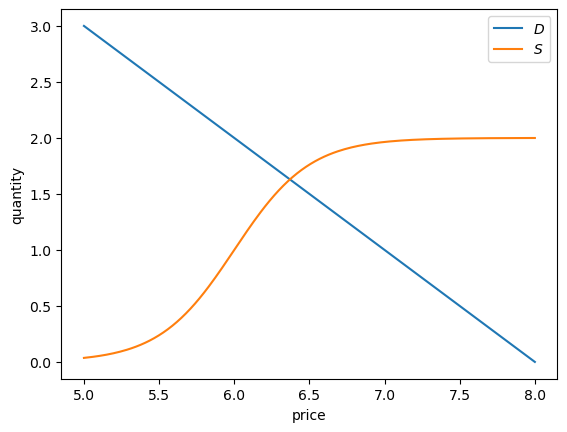

In [4]:
p_grid = np.linspace(5, 8, 200)
m = Market()
fig, ax = plt.subplots()

ax.plot(p_grid, m.demand(p_grid), label="$D$")
ax.plot(p_grid, m.supply(p_grid), label="$S$")
ax.set_xlabel("price")
ax.set_ylabel("quantity")
ax.legend()

plt.show()

Market equilibrium requires that supply equals demand, or

$$
    a - b p_t = S(p^e_t)
$$

Rewriting in terms of $p_t$ gives

$$
    p_t = - \frac{1}{b} [S(p^e_t) - a]
$$

Finally, to complete the model, we need to describe how price expectations are formed.

We will assume that expected prices at time $t$ depend on past prices.

In particular, we suppose that

```{math}
:label: p_et
    p^e_t = f(p_{t-1}, p_{t-2})
```

where $f$ is some function.

Thus, we are assuming that producers expect the time-$t$ price to be some function of lagged prices, up to $2$ lags.

(We could of course add additional lags and readers are encouraged to experiment with such cases.)

Combining the last two equations gives the dynamics for prices:

```{math}
:label: price_t
    p_t = - \frac{1}{b} [ S(f(p_{t-1}, p_{t-2})) - a]
```

The price dynamics depend on the parameter values and also on the function $f$ that determines how producers form expectations.

## Naive expectations

To go further in our analysis we need to specify the function $f$; that is, how expectations are formed.

Let's start with naive expectations, which refers to the case where producers expect the next period spot price to be whatever the price is in the current period.

In other words,

$$ 
p_t^e = p_{t-1} 
$$

Using {eq}`price_t`, we then have

$$
    p_t = - \frac{1}{b} [ S(p_{t-1}) - a]
$$

We can write this as

$$
    p_t = g(p_{t-1})
$$

where $g$ is the function defined by

```{math}
:label: def_g
    g(p) = - \frac{1}{b} [ S(p) - a]
```

Here we represent the function $g$

In [5]:
def g(model, current_price):
    """
    Function to find the next price given the current price
    and Market model
    """
    a, b = model.a, model.b
    next_price = - (model.supply(current_price) - a) / b
    return next_price

Let's try to understand how prices will evolve using a 45-degree diagram, which is a tool for studying one-dimensional dynamics.

The function `plot45` defined below helps us draw the 45-degree diagram.

In [6]:
def plot45(model, pmin, pmax, p0, num_arrows=5):
    """
    Function to plot a 45 degree plot

    Parameters
    ==========

    model: Market model

    pmin: Lower price limit

    pmax: Upper price limit

    p0: Initial value of price (needed to simulate prices)

    num_arrows: Number of simulations to plot
    """
    pgrid = np.linspace(pmin, pmax, 200)

    fig, ax = plt.subplots()
    ax.set_xlim(pmin, pmax)
    ax.set_ylim(pmin, pmax)

    hw = (pmax - pmin) * 0.01
    hl = 2 * hw
    arrow_args = dict(fc="k", ec="k", head_width=hw,
            length_includes_head=True, lw=1,
            alpha=0.6, head_length=hl)

    ax.plot(pgrid, g(model, pgrid), 'b-',
            lw=2, alpha=0.6, label='g')
    ax.plot(pgrid, pgrid, lw=1, alpha=0.7, label='$45\degree$')

    x = p0
    xticks = [pmin]
    xtick_labels = [pmin]

    for i in range(num_arrows):
        if i == 0:
            ax.arrow(x, 0.0, 0.0, g(model, x),
                     **arrow_args)
        else:
            ax.arrow(x, x, 0.0, g(model, x) - x,
                     **arrow_args)
            ax.plot((x, x), (0, x), ls='dotted')

        ax.arrow(x, g(model, x),
                 g(model, x) - x, 0, **arrow_args)
        xticks.append(x)
        xtick_labels.append(r'$p_{}$'.format(str(i)))

        x = g(model, x)
        xticks.append(x)
        xtick_labels.append(r'$p_{}$'.format(str(i+1)))
        ax.plot((x, x), (0, x), '->', alpha=0.5, color='orange')

    xticks.append(pmax)
    xtick_labels.append(pmax)
    ax.set_ylabel(r'$p_{t+1}$')
    ax.set_xlabel(r'$p_t$')
    ax.set_xticks(xticks)
    ax.set_yticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_yticklabels(xtick_labels)

    bbox = (0., 1.04, 1., .104)
    legend_args = {'bbox_to_anchor': bbox, 'loc': 'upper right'}

    ax.legend(ncol=2, frameon=False, **legend_args, fontsize=14)
    plt.show()

Now we can set up a market and plot the 45-degree diagram.

In [7]:
m = Market()

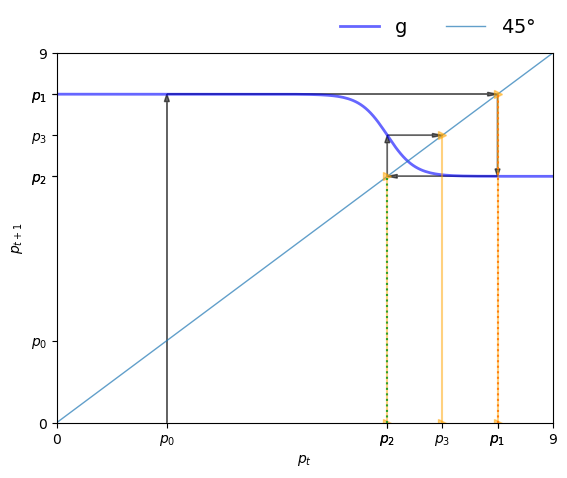

In [8]:
plot45(m, 0, 9, 2, num_arrows=3)

The plot shows the function $g$ defined in {eq}`def_g` and the 45-degree line.

Think of $ p_t $ as a value on the horizontal axis.

Since $p_{t+1} = g(p_t)$, we use the graph of $g$ to see $p_{t+1}$ on the vertical axis.

Clearly,

- If $ g $ lies above the 45-degree line at $p_t$, then we have $ p_{t+1} > p_t $.
- If $ g $ lies below the 45-degree line at $p_t$, then we have $ p_{t+1} < p_t $.
- If $ g $ hits the 45-degree line at $p_t$, then we have $ p_{t+1} = p_t $, so $ p_t $ is a steady state.

Consider the sequence of prices starting at $p_0$, as shown in the figure.

We find $p_1$ on the vertical axis and then shift it to the horizontal axis using the 45-degree line (where values on the two axes are equal).

Then from $p_1$ we obtain $p_2$ and continue.

We can see the start of a cycle.

To confirm this, let's plot a time series.

In [9]:
def ts_plot_price(model,             # Market model
                  p0,                # Initial price
                  y_a=3, y_b= 12,    # Controls y-axis
                  ts_length=10):     # Length of time series
    """
    Function to simulate and plot the time series of price.

    """
    fig, ax = plt.subplots()
    ax.set_xlabel(r'$t$', fontsize=12)
    ax.set_ylabel(r'$p_t$', fontsize=12)
    p = np.empty(ts_length)
    p[0] = p0
    for t in range(1, ts_length):
        p[t] = g(model, p[t-1])
    ax.plot(np.arange(ts_length),
            p,
            'bo-',
            alpha=0.6,
            lw=2,
            label=r'$p_t$')
    ax.legend(loc='best', fontsize=10)
    ax.set_ylim(y_a, y_b)
    ax.set_xticks(np.arange(ts_length))
    plt.show()

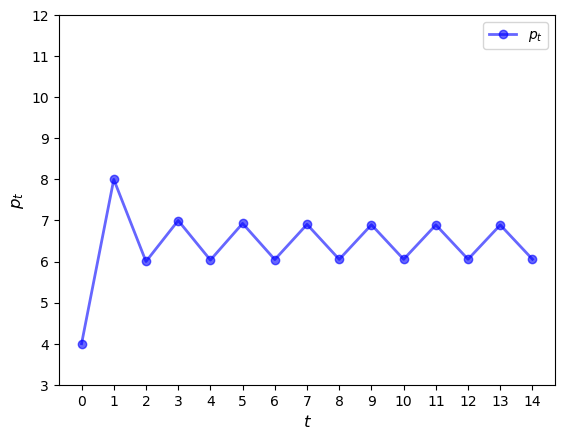

In [10]:
ts_plot_price(m, 4, ts_length=15)

We see that a cycle has formed and the cycle is persistent.

(You can confirm this by plotting over a longer time horizon.)

The cycle is "stable", in the sense that prices converge to it from most starting conditions.

For example,

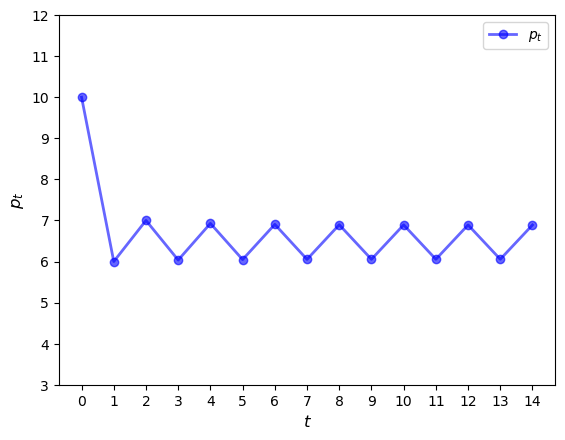

In [11]:
ts_plot_price(m, 10, ts_length=15)

## Adaptive expectations

Naive expectations are quite simple and also important in driving the cycle that we found.

What if expectations are formed in a different way?

Next we consider adaptive expectations.

This refers to the case where producers form expectations for
the next period price as a weighted average of their last guess and the
current spot price.

That is,

```{math}
:label: pe_adaptive
p_t^e = \alpha p_{t-1} + (1-\alpha) p^e_{t-1}
\qquad (0 \leq \alpha \leq 1)
```

Another way to write this is

```{math}
:label: pe_adaptive_2
p_t^e = p^e_{t-1} + \alpha (p_{t-1} - p_{t-1}^e)
```

This equation helps to show that expectations shift

1. up when prices last period were above expectations
1. down when prices last period were below expectations

Using {eq}`pe_adaptive`, we obtain the dynamics

$$
    p_t = - \frac{1}{b} [ S(\alpha p_{t-1} + (1-\alpha) p^e_{t-1}) - a]
$$

Let's try to simulate the price and observe the dynamics using different values of $\alpha$.

In [12]:
def find_next_price_adaptive(model, curr_price_exp):
    """
    Function to find the next price given the current price expectation
    and Market model
    """
    return - (model.supply(curr_price_exp) - model.a) / model.b

The function below plots price dynamics under adaptive expectations for different values of $\alpha$.

In [13]:
def ts_price_plot_adaptive(model, p0, ts_length=10, α=[1.0, 0.9, 0.75]):
    fig, axs = plt.subplots(1, len(α), figsize=(12, 5))
    for i_plot, a in enumerate(α):
        pe_last = p0
        p_values = np.empty(ts_length)
        p_values[0] = p0
        for i in range(1, ts_length):
            p_values[i] = find_next_price_adaptive(model, pe_last)
            pe_last = a*p_values[i] + (1 - a)*pe_last

        axs[i_plot].plot(np.arange(ts_length), p_values)
        axs[i_plot].set_title(r'$\alpha={}$'.format(a))
        axs[i_plot].set_xlabel('t')
        axs[i_plot].set_ylabel('price')
    plt.show()

Let's call the function with prices starting at $p_0 = 5$.

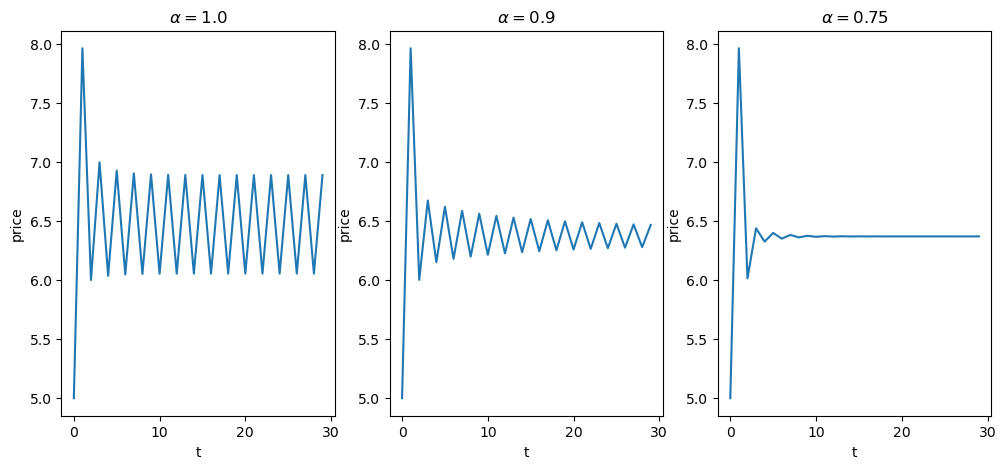

In [14]:
ts_price_plot_adaptive(m, 5, ts_length=30)

Note that if $\alpha=1$, then adaptive expectations are just naive expectation.

Decreasing the value of $\alpha$ shifts more weight to the previous
expectations, which stabilizes expected prices.

This increased stability can be seen in the figures.

## Exercises

```{exercise-start}
:label: cobweb_ex1
```
Using the default `Market` class and naive expectations, plot a time series simulation of supply (rather than the price).

Show, in particular, that supply also cycles.

```{exercise-end}
```

```{solution-start} cobweb_ex1
:class: dropdown
```

In [15]:
def ts_plot_supply(model, p0, ts_length=10):
    """
    Function to simulate and plot the supply function
    given the initial price.
    """
    pe_last = p0
    s_values = np.empty(ts_length)
    for i in range(ts_length):
        # store quantity
        s_values[i] = model.supply(pe_last)
        # update price
        pe_last = - (s_values[i] - model.a) / model.b


    fig, ax = plt.subplots()
    ax.plot(np.arange(ts_length),
            s_values,
            'bo-',
            alpha=0.6,
            lw=2,
            label=r'supply')

    ax.legend(loc='best', fontsize=10)
    ax.set_xticks(np.arange(ts_length))
    ax.set_xlabel("time")
    ax.set_ylabel("quantity")
    plt.show()

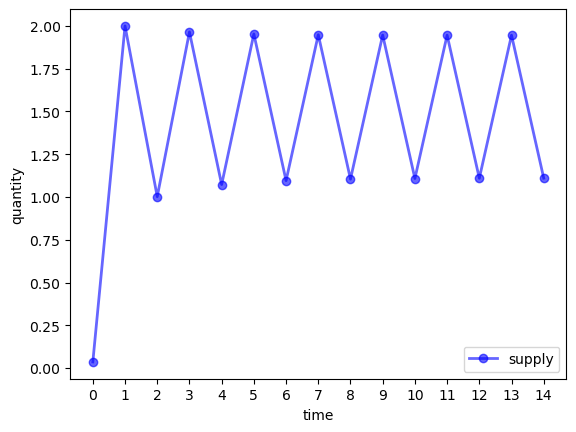

In [16]:
m = Market()
ts_plot_supply(m, 5, 15)

```{solution-end}
```

```{exercise-start}
:label: cobweb_ex2
```
**Backward looking average expectations**

Backward looking average expectations refers to the case where producers form
expectations for the next period price as a linear combination of their last
guess and the second last guess.

That is,

```{math}
:label: pe_blae
p_t^e = \alpha p_{t-1} + (1-\alpha) p_{t-2}
```


Simulate and plot the price dynamics for $\alpha \in \{0.1, 0.3, 0.5, 0.8\}$ where $p_0=1$ and $p_1=2.5$.

```{exercise-end}
```

```{solution-start} cobweb_ex2
:class: dropdown
```

In [17]:
def find_next_price_blae(model, curr_price_exp):
    """
    Function to find the next price given the current price expectation
    and Market model
    """
    return - (model.supply(curr_price_exp) - model.a) / model.b

In [18]:
def ts_plot_price_blae(model, p0, p1, alphas, ts_length=15):
    """
    Function to simulate and plot the time series of price
    using backward looking average expectations.
    """
    fig, axes = plt.subplots(len(alphas), 1, figsize=(8, 16))

    for ax, a in zip(axes.flatten(), alphas):
        p = np.empty(ts_length)
        p[0] = p0
        p[1] = p1
        for t in range(2, ts_length):
            pe = a*p[t-1] + (1 - a)*p[t-2]
            p[t] = -(model.supply(pe) - model.a) / model.b
        ax.plot(np.arange(ts_length),
                p,
                'o-',
                alpha=0.6,
                label=r'$\alpha={}$'.format(a))
        ax.legend(loc='best', fontsize=10)
        ax.set_xlabel(r'$t$', fontsize=12)
        ax.set_ylabel(r'$p_t$', fontsize=12)
    plt.show()

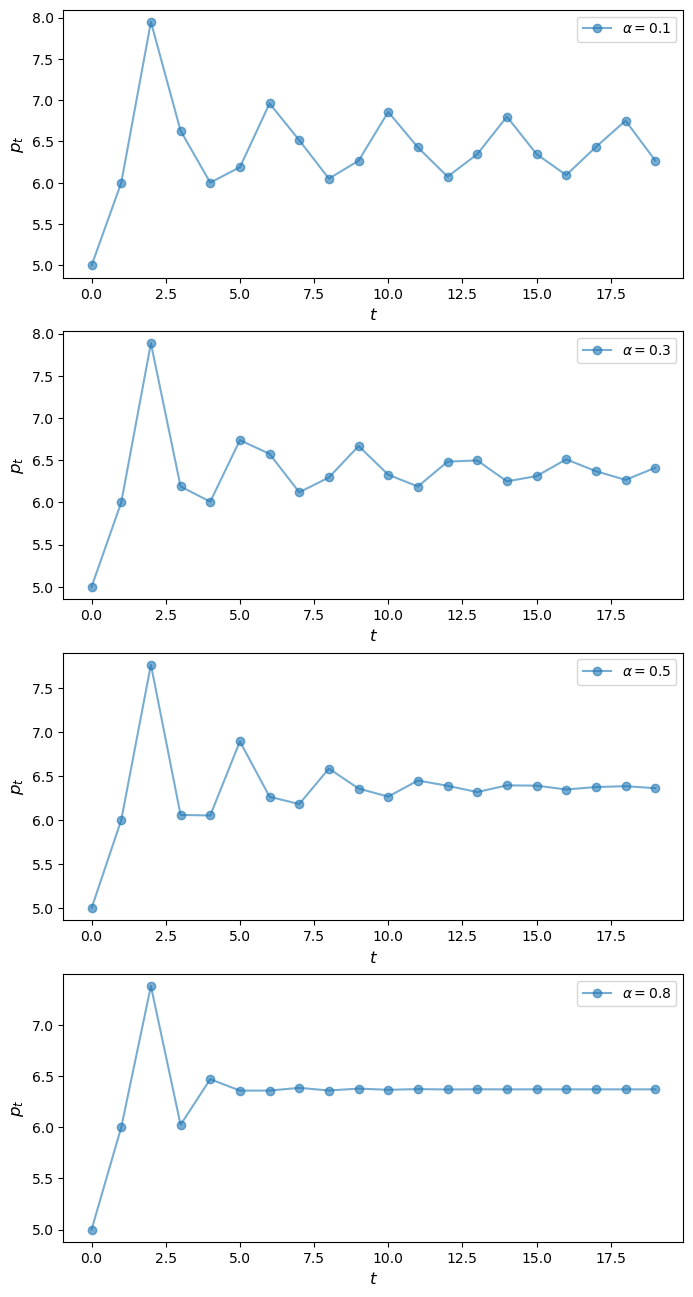

In [19]:
m = Market()
ts_plot_price_blae(m, 
                   p0=5, 
                   p1=6, 
                   alphas=[0.1, 0.3, 0.5, 0.8], 
                   ts_length=20)

```{solution-end}
```